# 1. Libraries and Data
In this first section I import the data into the work space, and give it the necessary format to be used during the stochastic modeling process.

In [27]:
# Libraries
import pandas as pd
import numpy as np
import datetime 
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
%load_ext autoreload
%autoreload 2
import stochastic_modeling as stc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
full_rates = pd.read_csv('historico_tasas_python.csv',index_col=0).astype(
    {'Fecha':'datetime64[ns]'}
).set_index('Fecha', drop=True)
full_rates

,TIBR,IBR Overnight,IBR 1M,IBR 3M,IBR 6M,DTF,IPC Anual,IPC Mensual,FED,UVR,...,IBC,USURA,TRM,DEV. TRM,LIBOR,SOFR,LEMPIRA/USD,DEV. LEMPIRA,COLON/USD,DEV. COLON
Fecha,,,,,,,,,,,,,,,,,,,,,
1999-01-01,0.26,NaN,NaN,NaN,NaN,0.3433,0.1635,0.0017,NaN,NaN,...,0.4549,0.68235,1542.11,0.192126,NaN,NaN,NaN,NaN,271.65,0.110907
1999-01-02,0.26,NaN,NaN,NaN,NaN,0.3433,0.1635,0.0017,NaN,NaN,...,0.4549,0.68235,1542.11,0.192126,NaN,NaN,NaN,NaN,271.65,0.110907
1999-01-03,0.26,NaN,NaN,NaN,NaN,0.3433,0.1635,0.0017,NaN,NaN,...,0.4549,0.68235,1542.11,0.182300,NaN,NaN,NaN,NaN,271.65,0.110680
1999-01-04,0.26,NaN,NaN,NaN,NaN,0.3406,0.1635,0.0017,NaN,NaN,...,0.4549,0.68235,1542.11,0.182300,NaN,NaN,NaN,NaN,271.65,0.110680
1999-01-05,0.26,NaN,NaN,NaN,NaN,0.3406,0.1635,0.0017,NaN,NaN,...,0.4549,0.68235,1545.11,0.184601,NaN,NaN,NaN,NaN,271.85,0.111497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-05,0.02,0.01980,0.02039,0.02430,0.03000,0.0204,0.0444,0.0045,0.0025,286.3298,...,0.1708,0.25620,3786.05,-0.024666,0.001551,0.0005,24.2507,-0.014644,629.65,0.040916
2021-10-06,0.02,0.01976,0.02060,0.02456,0.03043,0.0204,0.0451,0.0038,0.0025,286.3726,...,0.1708,0.25620,3796.30,-0.012345,0.001561,0.0005,24.2507,-0.014536,629.12,0.041710
2021-10-07,0.02,0.01975,0.02048,0.02460,0.03038,0.0204,0.0451,0.0038,0.0025,286.4155,...,0.1708,0.25620,3788.03,-0.010123,0.001559,0.0005,24.2507,-0.014239,630.13,0.040351


In [16]:
monthly_rates = full_rates.groupby(pd.Grouper(freq='M')).last()

In [17]:
full_rates['TIBR'].last('1M')

Fecha
2021-10-01    0.02
2021-10-02    0.02
2021-10-03    0.02
2021-10-04    0.02
2021-10-05    0.02
2021-10-06    0.02
2021-10-07    0.02
2021-10-08    0.02
2021-10-09    0.02
Name: TIBR, dtype: float64

In [30]:
trm = monthly_rates['TRM']


In [19]:
df_1 = pd.DataFrame(np.tile(monthly_rates['TIBR'], (100,1)).T, index = monthly_rates.index)
temp_index = pd.date_range(
    start = df_1.index[-1]+relativedelta(months=1),
    end = df_1.index[-1]+relativedelta(months=10),
    freq = 'M'
)
temp_data = np.random.normal(size=(10,100))
df_2 = pd.DataFrame(temp_data, index=temp_index)

In [20]:
concat_df = pd.concat([df_1, df_2])

In [21]:
concat_df.loc[concat_df.index[0]-relativedelta(months=1), :] = 1


In [22]:
concat_df.sort_index()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
1998-12-31,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1999-01-31,0.260000,0.260000,0.260000,0.260000,0.260000,0.260000,0.260000,0.260000,0.260000,0.260000,...,0.260000,0.260000,0.260000,0.260000,0.260000,0.260000,0.260000,0.260000,0.260000,0.260000
1999-02-28,0.240000,0.240000,0.240000,0.240000,0.240000,0.240000,0.240000,0.240000,0.240000,0.240000,...,0.240000,0.240000,0.240000,0.240000,0.240000,0.240000,0.240000,0.240000,0.240000,0.240000
1999-03-31,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,...,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000
1999-04-30,0.190000,0.190000,0.190000,0.190000,0.190000,0.190000,0.190000,0.190000,0.190000,0.190000,...,0.190000,0.190000,0.190000,0.190000,0.190000,0.190000,0.190000,0.190000,0.190000,0.190000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-30,-0.484227,-0.455955,-0.410842,0.200403,0.753863,-0.034516,-0.811441,-0.032785,-1.134759,0.211112,...,-1.824214,-0.441865,-1.444942,-0.328244,-0.457331,1.780251,-1.020229,0.102773,-0.515487,0.185292
2022-05-31,-0.487556,-1.838457,-0.192950,0.317652,0.637072,-0.581900,-0.063542,-0.052054,0.520176,-0.799359,...,1.286011,1.942101,-1.519331,-0.237443,0.357966,1.263735,-0.317898,0.069508,1.165148,-0.233269
2022-06-30,1.194141,0.805654,-1.531779,-0.620481,-0.626679,0.133386,-0.588821,-0.990486,-0.181250,0.108278,...,-0.513877,-1.437570,-1.482505,1.272607,-1.273141,0.590157,0.693739,-1.102568,1.632960,1.506695
2022-07-31,-0.684267,-0.299830,0.013368,-0.312245,0.154344,0.112552,-0.818806,-1.116238,-0.056147,-0.301912,...,-0.238358,-0.817255,-0.649881,0.978832,-1.468486,1.475421,-0.243557,-0.490970,-0.744084,1.503556


In [23]:
pd.date_range(tibr.index[-1]+ relativedelta(months=1), tibr.index[-1]+ relativedelta(months=60))

DatetimeIndex(['2021-11-30', '2021-12-01', '2021-12-02', '2021-12-03',
               '2021-12-04', '2021-12-05', '2021-12-06', '2021-12-07',
               '2021-12-08', '2021-12-09',
               ...
               '2026-10-22', '2026-10-23', '2026-10-24', '2026-10-25',
               '2026-10-26', '2026-10-27', '2026-10-28', '2026-10-29',
               '2026-10-30', '2026-10-31'],
              dtype='datetime64[ns]', length=1797, freq='D')

In [24]:
np.log(full_rates['TRM']/full_rates['TRM'].shift(1)).dropna()

Fecha
1999-01-02    0.000000
1999-01-03    0.000000
1999-01-04    0.000000
1999-01-05    0.001943
1999-01-06   -0.010952
                ...   
2021-10-05    0.001242
2021-10-06    0.002704
2021-10-07   -0.002181
2021-10-08   -0.004124
2021-10-09   -0.001762
Name: TRM, Length: 8317, dtype: float64

In [25]:
tibr[tibr.index[-1]]

0.02

In [31]:
trm_gbm = stc.GBMRateSeries(trm)

<AxesSubplot:>

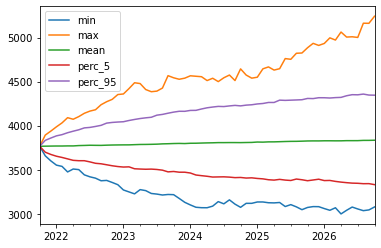

In [36]:
def perc_5(x):
    return x.quantile(0.05)
def perc_95(x):
    return x.quantile(0.95)
trm_gbm.sim_df.agg(['min','max', 'mean', perc_5, perc_95],axis=1).plot()

In [37]:
trm.max()

4064.81

In [45]:
ts = trm.idxmin()

In [46]:
ts.strftime('%Y-%m')

'1999-03'